# Prerequisites

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import importlib
from datetime import datetime, timedelta
import numpy as np

is_on_colab = False

In [2]:
# Optiional: Connect to Google Colab
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    timenow = datetime.now()+timedelta(hours=-7)
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive/Chronical/2024_07/PNC_Capstone")
    is_on_colab = True
else:
    print('Running on Local')
    timenow = datetime.now()
    is_on_colab = False

timenow_str = f"{timenow.hour:02d}{timenow.minute:02d}{timenow.month:02d}{timenow.day:02d}"

Running on Local


In [2]:
import Hypers
importlib.reload(Hypers)
import utils
importlib.reload(utils)
import Trainer
importlib.reload(Trainer)

utils.fix_random_seed(1127)#Hypers.Config.seed)

if is_on_colab:
  Hypers.Config.base_path = os.getcwd()
  Hypers.Config.data_path = os.path.join(Hypers.Config.base_path, "data")
  Hypers.Config.model_path = os.path.join(Hypers.Config.base_path, "model")
  Hypers.Config.log_path = os.path.join(Hypers.Config.base_path, "log")

print(f"{Hypers.Config.base_path=}")
print(f"{Hypers.Config.data_path=}")
print(f"{Hypers.Config.model_path=}")
print(f"{Hypers.Config.log_path=}")

Hypers.Config.base_path='c:\\Users\\Ryo\\Desktop\\PNC_Capstone'
Hypers.Config.data_path='c:\\Users\\Ryo\\Desktop\\PNC_Capstone\\data'
Hypers.Config.model_path='c:\\Users\\Ryo\\Desktop\\PNC_Capstone\\model'
Hypers.Config.log_path='c:\\Users\\Ryo\\Desktop\\PNC_Capstone\\log'


In [3]:
suffix = "RetInd"
window_size = 8

In [4]:
import CompustatExtractor
importlib.reload(CompustatExtractor)
from CompustatExtractor import CompustatExtractor

dataset_path = os.path.join(Hypers.Config.data_path, "WRDS", f"dataset_{suffix}.pkl")
dataset_noCPI_path = os.path.join(Hypers.Config.data_path, "WRDS", f"dataset_{suffix}_noCPI.pkl")

features = CompustatExtractor.process_compustat_features(
	os.path.join(Hypers.Config.data_path, "WRDS", f"features_{suffix}.csv"),
	save=False,
	filestem=f"features_{suffix}",
	add_cpi=True
)

concatenate_features = CompustatExtractor.concatenate_features(features, k=window_size)

ratings = CompustatExtractor.process_compustat_ratings(
	os.path.join(Hypers.Config.data_path, "WRDS", f"ratings_{suffix}.csv"),
	save=False,
	filestem=f"ratings_{suffix}"
)

merged_dict = CompustatExtractor.merge_input_output_dicts(
	concatenate_features,
	ratings,
	save=True,
	filestem=f"dataset_{suffix}_{window_size}"
)


input_dict: 924
output_dict: 392
merged_dict: 342


### Data preprocessing

In [4]:
import itertools

preprocessing_options = [
    {"standardize": True, "power_transformation": True},
    {"standardize": True, "power_transformation": False},
    {"standardize": False, "power_transformation": True},
    {"standardize": False, "power_transformation": False},
]

architecture_options = [
    {"dropout": True, "batch_norm": True, "num_conv_layers": 2},
    {"dropout": True, "batch_norm": True, "num_conv_layers": 1},
    {"dropout": False, "batch_norm": False, "num_conv_layers": 2},
    {"dropout": False, "batch_norm": False, "num_conv_layers": 1},
]

hyperparameter_options = list(itertools.product(
    [0, 1e-4], #reg decay
    [nn.ReLU, nn.SiLU] #activation function
))

# Conv1d

In [14]:
import ConvDataset
importlib.reload(ConvDataset)
import ConvModel2
importlib.reload(ConvModel2)

model_type = "Conv"

In [5]:
def apply_scaler(data_dict, scaler):
    scaled_dict = {}
    for company, data in data_dict.items():
        scaled_dict[company] = {}
        for period, (features, label, label_normalized) in data.items():
            features = scaler.transform(features.reshape(1, -1)).reshape(features.shape)
            scaled_dict[company][period] = (features, label, label_normalized)
    return scaled_dict

In [6]:
from sklearn.preprocessing import PowerTransformer

def apply_power_transformation(data_dict):
    transformer = PowerTransformer(method='yeo-johnson')
    all_features = []
    for company, data in data_dict.items():
        for period, (features, label, label_normalized) in data.items():
            features = np.clip(features, a_min=-1e6, a_max=1e6)
            all_features.append(features.reshape(1, -1))
    
    transformer.fit(np.vstack(all_features))
    
    transformed_dict = {}
    for company, data in data_dict.items():
        transformed_dict[company] = {}
        for period, (features, label, label_normalized) in data.items():
            transformed_features = transformer.transform(features.reshape(1, -1)).reshape(features.shape)
            transformed_dict[company][period] = (transformed_features, label, label_normalized)
    
    return transformed_dict

#### Kernel Size = 3

In [19]:
kernel_size = 3

In [20]:
from sklearn.preprocessing import StandardScaler

results_over_threshold = []
threshold = 0
best_history = []
best_acc = 0

preprocess = {"standardize": True, "power_transformation": True} 
merged_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"dataset_{suffix}_{window_size}.pkl"))
    
if preprocess["standardize"]:
    scaler = StandardScaler()
    all_features = []
    for company, data in merged_dict.items():
        for period, (features, label, label_normalized) in data.items():
            all_features.append(features.reshape(1, -1))
    scaler.fit(np.vstack(all_features))
    
    merged_dict = apply_scaler(merged_dict, scaler)

if preprocess["power_transformation"]:        
    merged_dict = apply_power_transformation(merged_dict)

train_dict, test_dict = utils.spilt_train_valid(merged_dict, random_select=True, save=True, suffix=suffix)

architecture = {"dropout": True, "batch_norm": True, "num_conv_layers": 2}
reg_param = 1e-4
activation_fn = nn.SiLU
input_size = len(next(iter(next(iter(train_dict.values())).values()))[0]) // window_size
model = ConvModel2.ConvModel(feature_size=input_size,
                            num_conv_layers=architecture["num_conv_layers"],
                            dropout=architecture["dropout"],
                            batch_norm=architecture["batch_norm"],
                            activation_fn=activation_fn,
                            kernel_size=kernel_size)

train_set = ConvDataset.ConvDataset(train_dict, window_size=window_size)
valid_set = ConvDataset.ConvDataset(test_dict, window_size=window_size)

train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn2)
valid_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn2)

criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate, weight_decay=reg_param)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainer = Trainer.Trainer(model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            device=device,
                            train_loader=train_loader,
                            valid_loader=valid_loader,
                            model_type=model_type)

train_loss, train_accuracy, valid_loss, valid_accuracy = trainer.train_loop()
print(f"Combination: Preprocess={preprocess}, Architecture={architecture}, Reg Param={reg_param}, Activation={activation_fn.__name__}\n-> Valid Accuracy: {valid_accuracy[-1]}")

if valid_accuracy[-1] > threshold:
    results_over_threshold.append({
        "preprocess": preprocess,
        "architecture": architecture,
        "reg_param": reg_param,
        "activation_fn": activation_fn.__name__,
        "valid_accuracy": valid_accuracy[-1]
    })
if best_acc < valid_accuracy[-1]:
    best_history = [train_loss, train_accuracy, valid_loss, valid_accuracy]

# utils.plot_graph(train_loss, train_accuracy, valid_loss, valid_accuracy)


Vaild Epoch 99: 100%|██████████| 100/100 [02:17<00:00,  1.37s/it, Loss: 0.007]

Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.5174061433447099


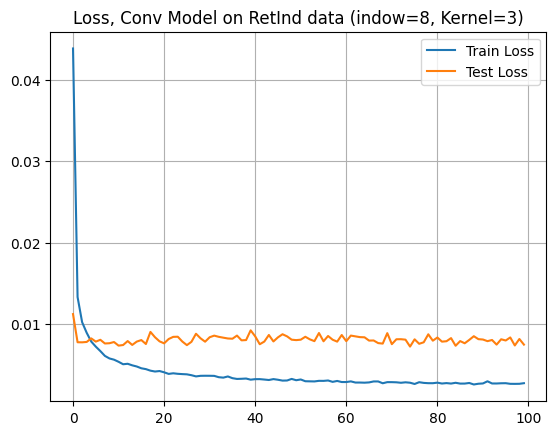

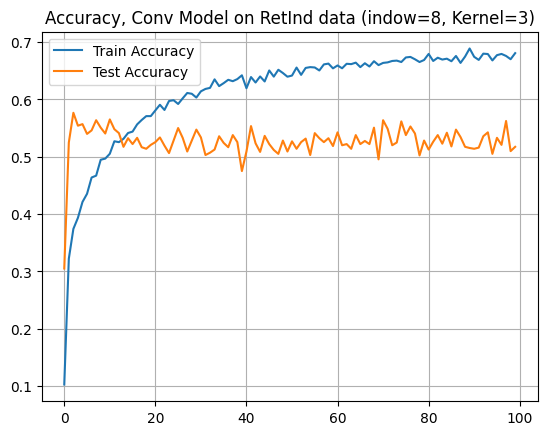

In [21]:
utils.plot_graph(*best_history, identifier="Conv Model on RetInd data (indow=8, Kernel=3)")

In [22]:
train_loss, train_accuracy, valid_loss, valid_accuracy = best_history
print(train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1])

0.0027619239536781554 0.680834739911002 0.007492161209062505 0.5174061433447099


In [6]:
import pickle

with open(f'result_RetInd_{window_size}_kernel{kernel_size}.pkl', 'wb') as file:
    pickle.dump(results_over_threshold, file)

#### Kernel size = 5

In [15]:
kernel_size = 5

In [16]:
from sklearn.preprocessing import StandardScaler

results_over_threshold = []
threshold = 0
best_history = []
best_acc = 0

preprocess = {"standardize": True, "power_transformation": True} 
merged_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"dataset_{suffix}_{window_size}.pkl"))
    
if preprocess["standardize"]:
    scaler = StandardScaler()
    all_features = []
    for company, data in merged_dict.items():
        for period, (features, label, label_normalized) in data.items():
            all_features.append(features.reshape(1, -1))
    scaler.fit(np.vstack(all_features))
    
    merged_dict = apply_scaler(merged_dict, scaler)

if preprocess["power_transformation"]:        
    merged_dict = apply_power_transformation(merged_dict)

train_dict, test_dict = utils.spilt_train_valid(merged_dict, random_select=True, save=True, suffix=suffix)

architecture = {"dropout": True, "batch_norm": True, "num_conv_layers": 2}
reg_param = 1e-4
activation_fn = nn.SiLU
input_size = len(next(iter(next(iter(train_dict.values())).values()))[0]) // window_size
model = ConvModel2.ConvModel(feature_size=input_size,
                            num_conv_layers=architecture["num_conv_layers"],
                            dropout=architecture["dropout"],
                            batch_norm=architecture["batch_norm"],
                            activation_fn=activation_fn,
                            kernel_size=kernel_size)

train_set = ConvDataset.ConvDataset(train_dict, window_size=window_size)
valid_set = ConvDataset.ConvDataset(test_dict, window_size=window_size)

train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn2)
valid_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn2)

criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate, weight_decay=reg_param)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainer = Trainer.Trainer(model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            device=device,
                            train_loader=train_loader,
                            valid_loader=valid_loader,
                            model_type=model_type)

train_loss, train_accuracy, valid_loss, valid_accuracy = trainer.train_loop()
print(f"Combination: Preprocess={preprocess}, Architecture={architecture}, Reg Param={reg_param}, Activation={activation_fn.__name__}\n-> Valid Accuracy: {valid_accuracy[-1]}")

if valid_accuracy[-1] > threshold:
    results_over_threshold.append({
        "preprocess": preprocess,
        "architecture": architecture,
        "reg_param": reg_param,
        "activation_fn": activation_fn.__name__,
        "valid_accuracy": valid_accuracy[-1]
    })
if best_acc < valid_accuracy[-1]:
    best_history = [train_loss, train_accuracy, valid_loss, valid_accuracy]

# utils.plot_graph(train_loss, train_accuracy, valid_loss, valid_accuracy)


Vaild Epoch 99: 100%|██████████| 100/100 [02:14<00:00,  1.35s/it, Loss: 0.008]

Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.5734304932735426


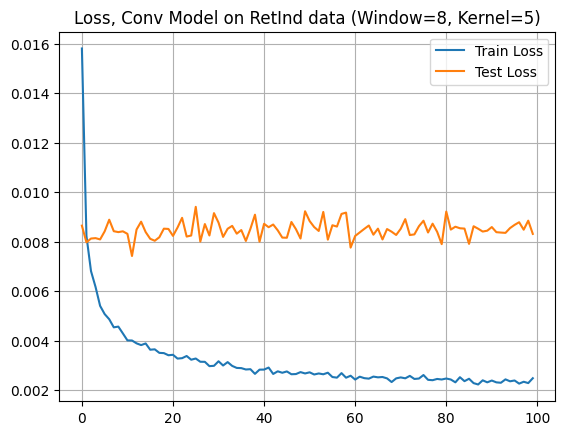

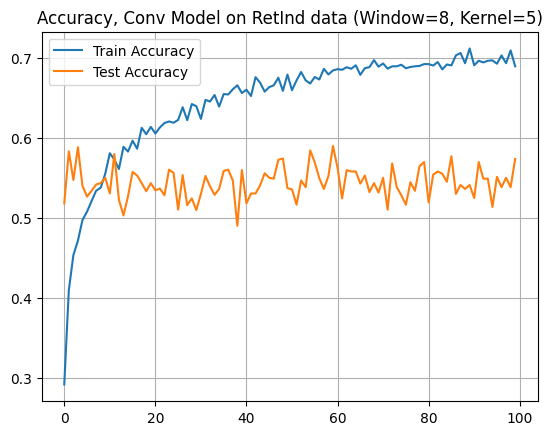

In [17]:
utils.plot_graph(*best_history, identifier="Conv Model on RetInd data (Window=8, Kernel=5)")

In [18]:
train_loss, train_accuracy, valid_loss, valid_accuracy = best_history
print(train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1])

0.002479909695011737 0.6890932558889965 0.008315981875253097 0.5734304932735426


#### Kernel size = 7

In [23]:
kernel_size = 7

In [24]:
from sklearn.preprocessing import StandardScaler

results_over_threshold = []
threshold = 0
best_history = []
best_acc = 0

preprocess = {"standardize": True, "power_transformation": True} 
merged_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"dataset_{suffix}_{window_size}.pkl"))
    
if preprocess["standardize"]:
    scaler = StandardScaler()
    all_features = []
    for company, data in merged_dict.items():
        for period, (features, label, label_normalized) in data.items():
            all_features.append(features.reshape(1, -1))
    scaler.fit(np.vstack(all_features))
    
    merged_dict = apply_scaler(merged_dict, scaler)

if preprocess["power_transformation"]:        
    merged_dict = apply_power_transformation(merged_dict)

train_dict, test_dict = utils.spilt_train_valid(merged_dict, random_select=True, save=True, suffix=suffix)

architecture = {"dropout": True, "batch_norm": True, "num_conv_layers": 2}
reg_param = 1e-4
activation_fn = nn.SiLU
input_size = len(next(iter(next(iter(train_dict.values())).values()))[0]) // window_size
model = ConvModel2.ConvModel(feature_size=input_size,
                            num_conv_layers=architecture["num_conv_layers"],
                            dropout=architecture["dropout"],
                            batch_norm=architecture["batch_norm"],
                            activation_fn=activation_fn,
                            kernel_size=kernel_size)

train_set = ConvDataset.ConvDataset(train_dict, window_size=window_size)
valid_set = ConvDataset.ConvDataset(test_dict, window_size=window_size)

train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn2)
valid_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn2)

criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate, weight_decay=reg_param)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainer = Trainer.Trainer(model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            device=device,
                            train_loader=train_loader,
                            valid_loader=valid_loader,
                            model_type=model_type)

train_loss, train_accuracy, valid_loss, valid_accuracy = trainer.train_loop()
print(f"Combination: Preprocess={preprocess}, Architecture={architecture}, Reg Param={reg_param}, Activation={activation_fn.__name__}\n-> Valid Accuracy: {valid_accuracy[-1]}")

if valid_accuracy[-1] > threshold:
    results_over_threshold.append({
        "preprocess": preprocess,
        "architecture": architecture,
        "reg_param": reg_param,
        "activation_fn": activation_fn.__name__,
        "valid_accuracy": valid_accuracy[-1]
    })
if best_acc < valid_accuracy[-1]:
    best_history = [train_loss, train_accuracy, valid_loss, valid_accuracy]

# utils.plot_graph(train_loss, train_accuracy, valid_loss, valid_accuracy)


Vaild Epoch 99: 100%|██████████| 100/100 [02:23<00:00,  1.43s/it, Loss: 0.005]

Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.5120994113799869


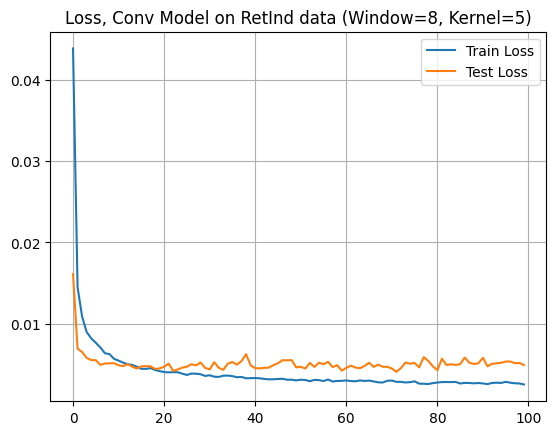

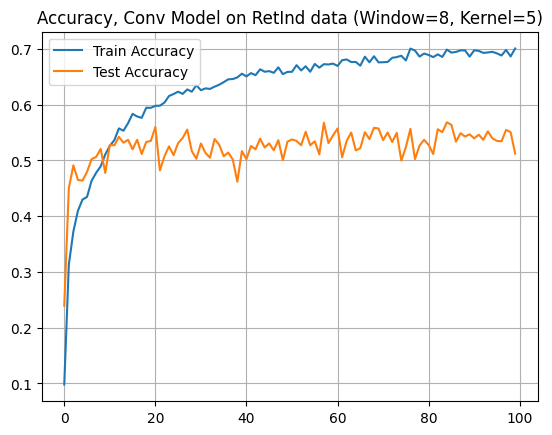

In [25]:
utils.plot_graph(*best_history, identifier="Conv Model on RetInd data (Window=8, Kernel=5)")

In [26]:
train_loss, train_accuracy, valid_loss, valid_accuracy = best_history
print(train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1])

0.0025009677124664467 0.7007593367426004 0.004899874227237202 0.5120994113799869


In [ ]:
import pickle

with open(f'result_RetInd_{window_size}_kernel{kernel_size}.pkl', 'wb') as file:
    pickle.dump(results_over_threshold, file)

In [4]:
import re

# 元の文字列データ
log_data = r"""
Vaild Epoch 99: 100%|██████████| 100/100 [04:30<00:00,  2.70s/it, Loss: 0.006]
Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.5102399063779989
Vaild Epoch 99: 100%|██████████| 100/100 [04:34<00:00,  2.75s/it, Loss: 0.006]
Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.5157987126974839
Vaild Epoch 99: 100%|██████████| 100/100 [04:35<00:00,  2.76s/it, Loss: 0.006]
Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.49151550614394385
Vaild Epoch 99: 100%|██████████| 100/100 [04:37<00:00,  2.77s/it, Loss: 0.006]
Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.5315974253949678
Vaild Epoch 99: 100%|██████████| 100/100 [03:37<00:00,  2.17s/it, Loss: 0.006]
Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.49853715623171446
Vaild Epoch 99: 100%|██████████| 100/100 [03:43<00:00,  2.24s/it, Loss: 0.006]
Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.5149210064365126
Vaild Epoch 99: 100%|██████████| 100/100 [03:50<00:00,  2.31s/it, Loss: 0.006]
Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.4906377998829725
Vaild Epoch 99: 100%|██████████| 100/100 [03:55<00:00,  2.35s/it, Loss: 0.006]
Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.5201872440023405
Vaild Epoch 99: 100%|██████████| 100/100 [03:54<00:00,  2.35s/it, Loss: 0.008]
Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.4596255119953189
Vaild Epoch 99: 100%|██████████| 100/100 [04:13<00:00,  2.54s/it, Loss: 0.008]
Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.46342890579286133
Vaild Epoch 99: 100%|██████████| 100/100 [04:10<00:00,  2.51s/it, Loss: 0.008]
Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.46489174956114687
Vaild Epoch 99: 100%|██████████| 100/100 [04:00<00:00,  2.41s/it, Loss: 0.008]
Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.46459918080748974
Vaild Epoch 99: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it, Loss: 0.008]
Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.449093036863663
Vaild Epoch 99: 100%|██████████| 100/100 [03:16<00:00,  1.96s/it, Loss: 0.008]
Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.4605032182562902
Vaild Epoch 99: 100%|██████████| 100/100 [03:19<00:00,  1.99s/it, Loss: 0.009]
Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.4534815681685196
Vaild Epoch 99: 100%|██████████| 100/100 [03:21<00:00,  2.01s/it, Loss: 0.007]
Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.4713282621416033
Vaild Epoch 99: 100%|██████████| 100/100 [04:40<00:00,  2.80s/it, Loss: 0.010]
Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.4302721088435374
Vaild Epoch 99: 100%|██████████| 100/100 [04:49<00:00,  2.89s/it, Loss: 0.011]
Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.43565759637188206
Vaild Epoch 99: 100%|██████████| 100/100 [04:49<00:00,  2.89s/it, Loss: 0.010]
Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.45351473922902497
Vaild Epoch 99: 100%|██████████| 100/100 [04:47<00:00,  2.87s/it, Loss: 0.010]
Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.45975056689342403
Vaild Epoch 99: 100%|██████████| 100/100 [03:28<00:00,  2.08s/it, Loss: 0.009]
Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.4574829931972789
Vaild Epoch 99: 100%|██████████| 100/100 [03:31<00:00,  2.12s/it, Loss: 0.010]
Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.4260204081632653
Vaild Epoch 99: 100%|██████████| 100/100 [03:32<00:00,  2.12s/it, Loss: 0.010]
Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.43339002267573695
Vaild Epoch 99: 100%|██████████| 100/100 [03:39<00:00,  2.19s/it, Loss: 0.010]
Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.44359410430839
Vaild Epoch 99: 100%|██████████| 100/100 [03:42<00:00,  2.22s/it, Loss: 0.010]
Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.4852607709750567
Vaild Epoch 99: 100%|██████████| 100/100 [03:47<00:00,  2.28s/it, Loss: 0.010]
Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.4688208616780045
Vaild Epoch 99: 100%|██████████| 100/100 [03:50<00:00,  2.30s/it, Loss: 0.009]
Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.49348072562358275
Vaild Epoch 99: 100%|██████████| 100/100 [03:50<00:00,  2.30s/it, Loss: 0.009]
Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.5045351473922902
Vaild Epoch 99: 100%|██████████| 100/100 [03:05<00:00,  1.85s/it, Loss: 0.010]
Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.4917800453514739
Vaild Epoch 99: 100%|██████████| 100/100 [03:18<00:00,  1.98s/it, Loss: 0.010]
Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.49121315192743764
Vaild Epoch 99: 100%|██████████| 100/100 [03:15<00:00,  1.95s/it, Loss: 0.010]
Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.48667800453514737
Vaild Epoch 99: 100%|██████████| 100/100 [03:22<00:00,  2.02s/it, Loss: 0.010]
Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.4951814058956916
"""

# 正規表現パターンを定義して、CombinationとValid Accuracyを抽出
pattern = r"Combination: Preprocess=(.*?), Architecture=(.*?), Reg Param=(.*?), Activation=(.*?)\n-> Valid Accuracy: ([\d\.]+)"
matches = re.findall(pattern, log_data, re.DOTALL)

# 抽出されたデータをリストに保存
results_over_threshold = []
for match in matches:
    preprocess = eval(match[0].strip())  # 文字列を辞書に変換
    architecture = eval(match[1].strip())  # 文字列を辞書に変換
    reg_param = float(match[2].strip())  # 正規化パラメータを数値に変換
    activation_fn = match[3].strip()  # 活性化関数名
    valid_accuracy = float(match[4].strip())  # 精度を数値に変換

    results_over_threshold.append({
        "preprocess": preprocess,
        "architecture": architecture,
        "reg_param": reg_param,
        "activation_fn": activation_fn,
        "valid_accuracy": valid_accuracy
    })

# 結果を表示
for result in results_over_threshold:
    print(result)

{'preprocess': {'standardize': True, 'power_transformation': True}, 'architecture': {'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, 'reg_param': 0.0, 'activation_fn': 'ReLU', 'valid_accuracy': 0.5102399063779989}
{'preprocess': {'standardize': True, 'power_transformation': True}, 'architecture': {'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, 'reg_param': 0.0, 'activation_fn': 'SiLU', 'valid_accuracy': 0.5157987126974839}
{'preprocess': {'standardize': True, 'power_transformation': True}, 'architecture': {'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, 'reg_param': 0.0001, 'activation_fn': 'ReLU', 'valid_accuracy': 0.49151550614394385}
{'preprocess': {'standardize': True, 'power_transformation': True}, 'architecture': {'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, 'reg_param': 0.0001, 'activation_fn': 'SiLU', 'valid_accuracy': 0.5315974253949678}
{'preprocess': {'standardize': True, 'power_transformation': True}, 'architecture': {'dro

In [8]:
sorted_results = sorted(results_over_threshold, key=lambda x: x["valid_accuracy"], reverse=True)

top_10_results = sorted_results[:10]

for i, result in enumerate(top_10_results, 1):
    print(f"  Preprocess: {result['preprocess']}")
    print(f"  Architecture: {result['architecture']}")
    print(f"  Regularization Parameter: {result['reg_param']}")
    print(f"  Activation Function: {result['activation_fn']}")
    print(f"  Validation Accuracy: {result['valid_accuracy']}")
    print()

  Preprocess: {'standardize': True, 'power_transformation': True}
  Architecture: {'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}
  Regularization Parameter: 0.0001
  Activation Function: SiLU
  Validation Accuracy: 0.5315974253949678

  Preprocess: {'standardize': True, 'power_transformation': True}
  Architecture: {'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}
  Regularization Parameter: 0.0001
  Activation Function: SiLU
  Validation Accuracy: 0.5201872440023405

  Preprocess: {'standardize': True, 'power_transformation': True}
  Architecture: {'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}
  Regularization Parameter: 0.0
  Activation Function: SiLU
  Validation Accuracy: 0.5157987126974839

  Preprocess: {'standardize': True, 'power_transformation': True}
  Architecture: {'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}
  Regularization Parameter: 0.0
  Activation Function: SiLU
  Validation Accuracy: 0.5149210064365126

  Preprocess: 

# -----------------

In [ ]:
train_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"train_dict_{suffix}.pkl"))
test_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"test_dict_{suffix}.pkl"))
print(f"{len(train_dict)=}", f"{len(test_dict)=}")
print(suffix)

len(train_dict)=283 len(test_dict)=59
Ret


In [ ]:
input_size = len(next(iter(next(iter(train_dict.values())).values()))[0]) // window_size
print(f"{input_size=}")

input_size=38


Vaild Epoch 199: 100%|██████████| 200/200 [05:10<00:00,  1.55s/it, Loss: 0.011]


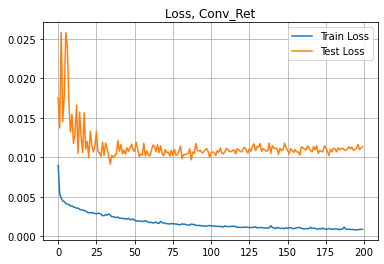

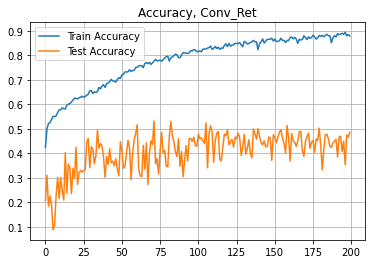

In [ ]:
train_set = ConvDataset.ConvDataset(train_dict, window_size=window_size)
valid_set = ConvDataset.ConvDataset(test_dict, window_size=window_size)
train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn)
valid_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn)

model = ConvModel.ConvModel(feature_size=input_size)
criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Trainer.Trainer(model=model,
                          criterion=criterion,
                          optimizer=optimizer,
                          device=device,
                          train_loader=train_loader,
                          valid_loader=valid_loader,
                          model_type=model_type)
train_loss, train_accuracy, valid_loss, valid_accuracy = trainer.train_loop()
utils.plot_graph(train_loss, train_accuracy, valid_loss, valid_accuracy, identifier=f"{model_type}_{suffix}")

# Infer

In [ ]:
import Inferencer
importlib.reload(Inferencer)

<module 'Inferencer' from '/Users/Ryo/Desktop/UCLA/PNC_Capstone/Inferencer.py'>

In [ ]:
import RegressionDataset
importlib.reload(RegressionDataset)
import RegressionModel
importlib.reload(RegressionModel)

test_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=False, collate_fn=RegressionDataset.RegressionDataset.custom_collate_fn)
inferencer = Inferencer.Inferencer(model=model, test_loader=test_loader, device=device)
predictions, turths, accuracy, diff_counter = inferencer.infer()

In [ ]:
nums = 10
print(predictions[:nums])
print(turths[:nums])

tensor([5., 5., 4., 4., 4., 4., 4., 4., 3., 4.])
tensor([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])


In [ ]:
print(diff_counter)

Counter({0.0: 666, 1.0: 549, 2.0: 109, 5.0: 25, 4.0: 8, 3.0: 7, 6.0: 5})


In [ ]:
total_count = sum(diff_counter.values())
print(f"{total_count=}")

total_count=1369


In [ ]:
accumulated_count = []

for i in range(0, 33):
    count = diff_counter[i]
    if i==0:
        accumulated_count.append(count)
        continue
    accumulated_count.append(accumulated_count[-1]+count)

accumulated_accuracy = [i/total_count for i in accumulated_count]
accumulated_accuracy[:5]

[0.4864864864864865,
 0.887509130752374,
 0.9671292914536158,
 0.9722425127830533,
 0.9780861943024105]

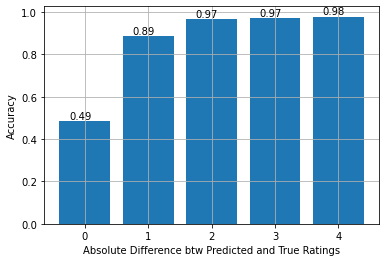

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(0,5), accumulated_accuracy[:5])
for i, v in enumerate(accumulated_accuracy[:5]):
    plt.text(i - 0.25, v + 0.01, str(round(v, 2)))
plt.xlabel("Absolute Difference btw Predicted and True Ratings")
plt.ylabel("Accuracy")
plt.grid()
plt.show()